# Simple Model Training
This script is used to generate a CNN tensorflow model using hyperparameter search, train it and print the results

In [1]:
# Importing packages
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import keras
import keras_tuner as kt
from keras.utils import to_categorical
from keras.layers import Dense, Convolution1D, Convolution2D, MaxPool1D, Flatten, Dropout, AveragePooling1D
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.utils import class_weight
from sklearn.utils import resample
import warnings
import os
warnings.filterwarnings('ignore')

In [2]:
# Training parameters
EPOCHS = 20
BATCH_SIZE = 32

The data is loaded from two ```.csv``` files and is already divided into labeled samples. Each row contains one ECG sample: columns 0 to 186 are the ECG reading and 187 is the sample classification:
    
    ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]

In [3]:
# Load data from file
train_df=pd.read_csv('src/mitbih_train.csv',header=None)
test_df=pd.read_csv('src/mitbih_test.csv',header=None)

#train_df.head()
#train_df.tail()

The data is divided into training and testing datasets and from each is extracted the vector containing the sample labels

In [4]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

The CNN model is defined

In [5]:
# Network Architecture Search with Tensorflow

def build_model(hp):
  model = keras.Sequential()
  
  # Standard input layer
  model.add(keras.layers.Input(shape=((X_train.shape[1],1)), name='inputs_cnn'))

  # Tune whether to use convolutional layers
  if hp.Boolean("conv_1"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_1", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_1", min_value=3, max_value=15, step=2),
                                          strides=hp.Int("strides_1", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
  
  if hp.Boolean("maxpool_1"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_1", min_value=1, max_value=6, step=1)))

  if hp.Boolean("conv_2"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_2", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_2", min_value=3, max_value=7, step=2),
                                          strides=hp.Int("strides_2", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
    
  if hp.Boolean("maxpool_2"):
    model.add(keras.layers.MaxPool1D(pool_size=hp.Int("pool_size_2", min_value=1, max_value=6, step=1)))

  if hp.Boolean("conv_3"):
    model.add(keras.layers.Convolution1D( filters=hp.Int("filters_3", min_value=1, max_value=5, step=1), 
                                          kernel_size=hp.Int("kernel_size_3", min_value=3, max_value=7, step=2),
                                          strides=hp.Int("strides_3", min_value=1, max_value=7, step=2), 
                                          padding="same", activation='relu'))
  
  # Flatten before dense layers
  model.add(keras.layers.Flatten())

  # Fixed dense layers
  model.add(keras.layers.Dense(30, activation='softmax', name='dense_1'))  
  model.add(keras.layers.Dense(5, activation='softmax', name='main_output'))

  # Tune the learning rate 
  learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
  model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
  )

  return model

build_model(kt.HyperParameters())

tuner = kt.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=15,
    executions_per_trial=2,
    overwrite=True,
    directory="my_dir",
    project_name="alg_8_peaks_nn",
)

tuner.search(X_train, y_train, epochs=4, validation_data=(X_test, y_test))




Trial 15 Complete [00h 01m 30s]
val_accuracy: 0.8276082873344421

Best val_accuracy So Far: 0.91645348072052
Total elapsed time: 00h 24m 06s


In [6]:
# Get the top 2 models.
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

model = best_model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ max_pooling1d (MaxPooling1D)    │ (None, 62, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 21, 5)          │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 105)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 30)             │         3,180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ main_output (Dense)             │ (None, 5)              │           155 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,355 (13.11 KB)

 Trainable params: 3,355 (13.11 KB)

 Non-trainable params: 0 (0.00 B)

The model is trained on the dataset and the resulting parameters are saved

In [7]:
# Disable filtering for error messages
keras.config.disable_traceback_filtering()

# Assign available number to current model
model_num = 0
while os.path.exists("models/cnn/model_%s.keras" % f"{model_num:02}"):
    model_num += 1
log_dir = "logs/cnn/"
#tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train model
#history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test), callbacks=[tensorboard_callback])
history=model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_test,y_test))

# Save trained model
model_name = 'model_'+ str(f"{model_num:02}")
model_path = 'models/cnn/' + model_name + '.keras'
model.name = model_name
model.save(model_path)

Epoch 1/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9259 - loss: 0.2577 - val_accuracy: 0.9344 - val_loss: 0.2351
Epoch 2/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9427 - loss: 0.2055 - val_accuracy: 0.9470 - val_loss: 0.1901
Epoch 3/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9499 - loss: 0.1768 - val_accuracy: 0.9515 - val_loss: 0.1729
Epoch 4/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9537 - loss: 0.1593 - val_accuracy: 0.9571 - val_loss: 0.1585
Epoch 5/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9561 - loss: 0.1506 - val_accuracy: 0.9582 - val_loss: 0.1603
Epoch 6/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9598 - loss: 0.1423 - val_accuracy: 0.9547 - val_loss: 0.1606
Epoch 7/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9613 - loss: 0.1360 - val_accuracy: 0.9607 - val_loss: 0.1484
Epoch 8/20
2737/2737 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9623 - loss: 0.1371 -

Calculate the confusion matrix to evaluate the model performance

In [8]:
y_prediction = model.predict(X_test)
y_prediction = np.argmax (y_prediction, axis = 1)
y_test=np.argmax(y_test, axis=1)

# Create confusion matrix and normalize it over predicted (columns)
result = confusion_matrix(y_test, y_prediction , normalize='pred')
classes = [0,1,2,3,4]
result_norm = np.around(result, 4)
mat_result = pd.DataFrame(result_norm,
                     index = classes, 
                     columns = classes)

total_pred = np.trace(result) / 5

print('Confusion matrix')
print(mat_result)
print()
print('Average accuracy')
print(total_pred)

685/685 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
Confusion matrix
        0       1       2       3       4
0  0.9726  0.0954  0.0669  0.0882  0.0329
1  0.0125  0.8954  0.0227  0.0074  0.0006
2  0.0076  0.0092  0.8739  0.1691  0.0084
3  0.0025  0.0000  0.0103  0.7353  0.0000
4  0.0047  0.0000  0.0262  0.0000  0.9580

Average accuracy
0.88703422963567


Plot the confusion matrix with a color gradient

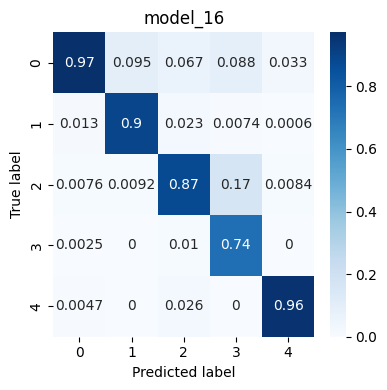

In [9]:
figure = plt.figure(figsize=(4, 4))
sns.heatmap(mat_result, annot=True,cmap=plt.cm.Blues)
plt.title(model_name)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(log_dir + '/' + model_name + '.png', pad_inches=0.1)
plt.show()